## YOLO for Object Detection

It is a challenging computer vision task that requires both successful object localization in order to locate and draw a bounding box around each object in an image, and object classification to predict the correct class of object that was localized.

It splits the input into a grid of cells and each cell directly predicts a bounding box and object classification. The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

Although the accuracy of the models is close but not as good as Region-Based Convolutional Neural Networks (R-CNNs), they are popular for object detection because of their detection speed, often demonstrated in real-time on video or with camera feed input.

    A single neural network predicts bounding boxes and class probabilities directly from full images in one evaluation. Since the whole detection pipeline is a single network, it can be optimized end-to-end directly on detection performance.
    
I will use experiencor’s keras-yolo3 project as the basis for performing object detection with a YOLOv3 model in this.

## Create and Save Model

The first step is to download the pre-trained model weights.

These were trained using the DarkNet code base on the MSCOCO dataset. Download the model weights and place them into your current working directory with the filename “yolov3.weights.” It is a large file and may take a moment to download depending on the speed of your internet connection. Here is the link to download the weights. https://pjreddie.com/media/files/yolov3.weights

For using those weights in colab we need to upload those in colab notebook. So the next some lines of code to download these weights in the colab notebook.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls


gdrive	sample_data


In [0]:
!pwd

/content


In [0]:
cd gdrive

/content/gdrive


In [0]:
cd 'My Drive'

/content/gdrive/My Drive


In [0]:
cd 'object detection'

/content/gdrive/My Drive/object detection


In [0]:
cd 'yolo- v3'

/content/gdrive/My Drive/object detection/yolo- v3


In [0]:
!ls

Untitled0.ipynb


In [0]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2019-07-22 14:35:13--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  18.3MB/s    in 14s     

2019-07-22 14:35:28 (16.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



Till this point weights are downloaded in the colab notebook and ready to use. Now we will go through codes of the project.

Next, we need to define a Keras model that has the right number and type of layers to match the downloaded model weights. The model architecture is called a “DarkNet” and was originally loosely based on the VGG-16 model.

The “yolo3_one_file_to_detect_them_all.py” script provides the make_yolov3_model() function to create the model for us, and the helper function _conv_block() that is used to create blocks of layers. These two functions can be copied directly from the script.

### Importing Libraries and functions to use.

In [0]:
# create a YOLOv3 Keras model and save it to file
# based on https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model


Using TensorFlow backend.


In [0]:
"""function _conv_block() that is used to create blocks of layers. """
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x


"""the make_yolov3_model() function to create the model for us"""
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

"""Next, we need to load the model weights. The model weights are stored in whatever format that was used by DarkNet. 
Rather than trying to decode the file manually, we can use the WeightReader class provided in the script.

To use the WeightReader, it is instantiated with the path to our weights file (e.g. ‘yolov3.weights‘). 
This will parse the file and load the model weights into memory in a format that we can set into our Keras model."""

class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
  
  """We can then call the load_weights() function of the WeightReader instance, passing in our defined Keras model 
  to set the weights into the layers."""

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0

# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

W0722 15:11:33.678644 140084520421248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 15:11:33.732823 140084520421248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 15:11:33.743402 140084520421248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 15:11:33.787436 140084520421248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 15:11:33.788577 1400845204

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

At the end of the run, the model.h5 file is saved in your current working directory with approximately the same size as the original weight file (237MB), but ready to be loaded and used directly as a Keras model.

### Make a Prediction

We need a new photo for object detection, ideally with objects that we know that the model knows about from the MSCOCO dataset.

We will use a photograph of three zebras. If you are running this in your Local machine then you should download some pictures for detection test(if you dont have already). I am using colab so, I ll download the picture in colab notebook.

In [0]:
!wget https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/zebra.jpg

--2019-07-22 15:37:30--  https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/zebra.jpg
Resolving 3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com (3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com)... 108.161.188.224
Connecting to 3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com (3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com)|108.161.188.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240195 (235K) [image/jpeg]
Saving to: ‘zebra.jpg’

zebra.jpg           100%[===================>] 234.57K  --.-KB/s    in 0.01s   

2019-07-22 15:37:30 (16.2 MB/s) - ‘zebra.jpg’ saved [240195/240195]



Making a prediction is straightforward, although interpreting the prediction requires some work.

In [0]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

"""decode_netout() that will take each one of the NumPy arrays, one at a time, and decode the candidate bounding boxes and class predictions. 
Further, any bounding boxes that don’t confidently describe an object (e.g. all class probabilities are below a threshold) are ignored. """

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

"""The experiencor script provides the correct_yolo_boxes() function to perform this translation of bounding box coordinates, 
taking the list of bounding boxes, the original shape of our loaded photograph, and the shape of the input to the network as arguments. 
The coordinates of the bounding boxes are updated directly."""

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

"""The experiencor script provides this via the do_nms() function that takes the list of bounding boxes and a threshold parameter. 
Rather than purging the overlapping boxes, their predicted probability for their overlapping class is cleared. 
This allows the boxes to remain and be used if they also detect another object type."""

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
          
"""load_image_pixels() that takes the filename and target size and returnsthe scaled pixel data 
ready to provide as input to the Keras model, as well as the original width and height of the image."""
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

"""We can develop a get_boxes() function that does this and takes the list of boxes, known labels, 
and our classification threshold as arguments and returns parallel lists of boxes, labels, and scores."""

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

"""The draw_boxes() function below implements this, taking the filename of the original photograph and the 
parallel lists of bounding boxes, labels and scores, and creates a plot showing all detected objects."""

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

## Loading our model for prediction

In [0]:
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## These are the classes that are used for training the DarkNet weights.
So we can classify/detect these types of objects using the trained model and weights.

In [0]:
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects

Now Load our Image and do the prediction.



[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 94.9106216430664
zebra 99.86329674720764
zebra 96.87086343765259


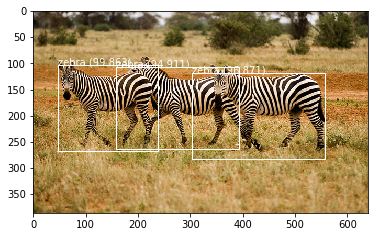

In [0]:

# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)

v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

Another image for prediction

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
dog 99.39103722572327
cat 98.81480932235718


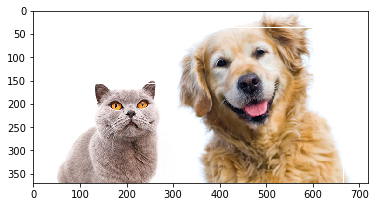

In [0]:
# define our new photo
photo_filename = '2-5-1-DogCatLookingAtCamera-750x250.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)

v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

One more Prediction of a single object


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
aeroplane 99.83131289482117


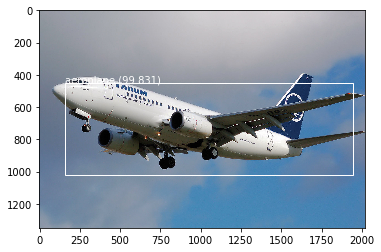

In [0]:
# define our new photo
photo_filename = 'Tarom.b737-700.yr-bgg.arp.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)

v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

Now multiple types of objects prediction

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
oven 96.30327820777893
tvmonitor 63.371193408966064
refrigerator 63.359516859054565
cup 72.58465886116028


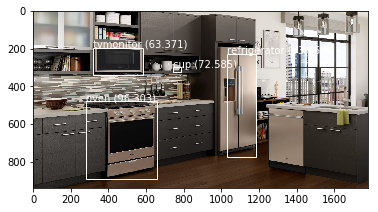

In [0]:
# define our new photo
photo_filename = 'style-hub-top-2018-06.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)

v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)